## Ocean pCO2 diagnostics for HOPE ensemble member 001

## CESM emissions-driven run tutorial

### By Kristen Krumhardt

# ---------------------------

### Import statements (using NPL 2023a environment)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools 
import pandas as pd
import utils_ocean as utils

### Grab years 1998 to 2015 of pCO2 from the model (includes historical and future forcing)

#### define case name and path

In [2]:
case1 = 'b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001'
path1 = '/glade/campaign/cesm/collections/CCISEns/archive/' + case1 + '/ocn/hist'

case2 = 'b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.001'
path2 = '/glade/campaign/cesm/collections/CCISEns/archive/' + case2 + '/ocn/hist'

#### define variable name and the variables to keep

In [3]:
variables = ['pCO2SURF'] 

keep_vars = ['z_t','z_t_150m','time_bound','TAREA',
             'REGION_MASK','dz','KMT','TLONG','TLONG','time','time_bounds'] + variables

#### Preprocessing function to just keep the variables we want

In [4]:
def preprocess(ds):
    ds=ds.drop([v for v in ds.variables if v not in keep_vars])
    return ds

#### Read in the data

In [5]:
%%time

files = []
years = np.arange(1998,2015,1)

## Make a list of the files needed
for year in years:
    print(year)
    yr4="{:04d}".format(year)
    for month in range(1, 13):
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'{path1}/{case1}.pop.h.{yr4}-{mo2}.nc')))

## Add the files for the last year from the SSP2 scenario
year = 2015
yr4="{:04d}".format(year)
print(year)
for month in range(1, 13):

    mo2="{:02d}".format(month)
    files.extend(sorted(glob(f'{path2}/{case2}.pop.h.{yr4}-{mo2}.nc')))
    
## open the dataset, preprocessing to just get the pCO2 (this step takes a minute or two)
ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time', combine='nested', preprocess=preprocess)

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
CPU times: user 1min 11s, sys: 2.05 s, total: 1min 13s
Wall time: 1min 32s


#### Make a mean of the time_bounds and then make a climatology over the 1998 to 2015 period

In [6]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")
ds = ds.groupby('time.month').mean('time')

### Get the [Landschützer et al. (2020)](https://essd.copernicus.org/articles/12/2537/2020/essd-12-2537-2020.pdf) pCO2 climatology observation-based product that covers 1998 to 2015

In [7]:
file = '/glade/work/kristenk/pCO2_obs_product/MPI-ULB-SOM_FFN_clim.nc'

ds_obs = xr.open_dataset(file)

### turn the -999s in the dataset to nans
ds_obs['pco2'] = ds_obs['pco2'].where(ds_obs['pco2'] != -999)

### Make maps for each month, comparing CESM to Landschützer

#### Use pop tools to get ocean grid info

In [8]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG

In [9]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

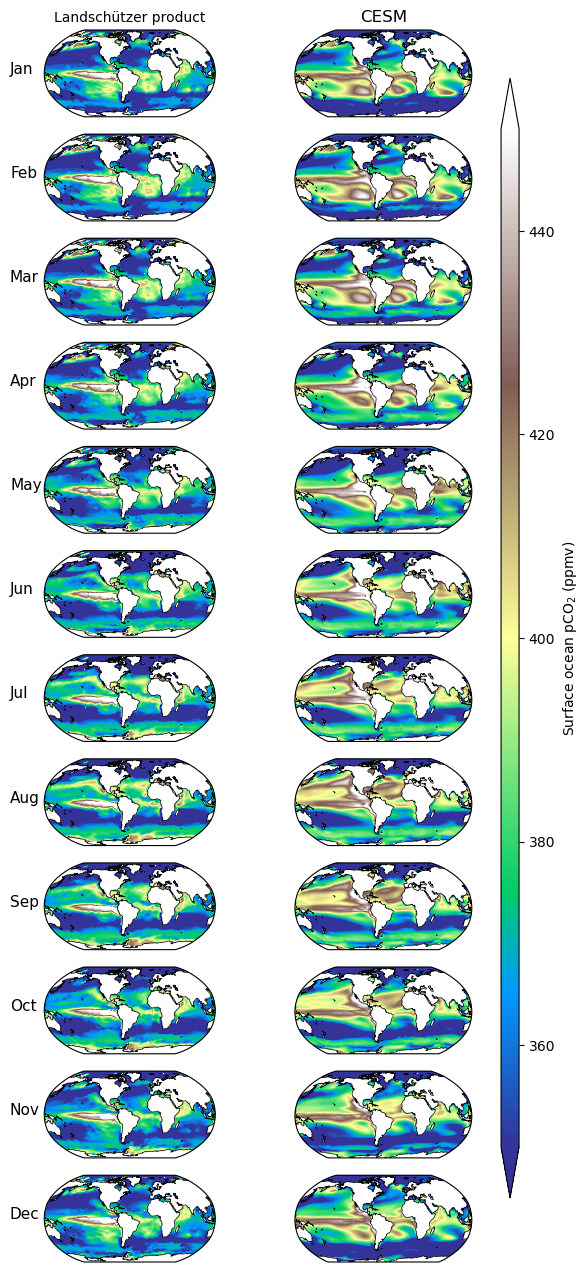

In [10]:
fig = plt.figure(figsize=(6,16))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    if row == 1:
        ax.set_title('Landschützer product', fontsize=10)
    pc=ax.pcolormesh(ds_obs.lon, ds_obs.lat, ds_obs.pco2.isel(time=ts), 
                     cmap='terrain',vmin=350,vmax=450,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    ax.text(-0.2,0.5, months[ts], fontsize=11, transform=ax.transAxes)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    if row == 1:
        ax.set_title('CESM', fontsize=12)
    tmp = ds.pCO2SURF.isel(month=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='terrain',vmin=350,vmax=450,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='both', label='Surface ocean pCO$_2$ (ppmv)');
